## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [3]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"

In [4]:
#일반적으로 transform 생성하는 방법. 아래쪽에서 이부분을 optuna & yaml 이용해 RabddAug로 구현. 
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [5]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [6]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [ ]:
##visualize augmentation before training
img_size = 32

augmentation_functions = (
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)), 
    transforms.RandomPerspective(),
    transforms.RandomHorizontalFlip(),
)

train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, aug_fcns = augmentation_functions, validation_ratio=0.8)
visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix="Trial 00 //")

In [7]:
import optuna
import yaml

In [8]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
    
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    
    #aug 결과 시각화
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    #모델 load
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    #optimizer, scheduler, loss
    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)
    #dataloader
    train_loader = DataLoader(dataset=train_dataset, 
                              pin_memory=torch.cuda.is_available(), 
                              shuffle=True, 
                              batch_size=BATCH_SIZE, 
                              num_workers=4, 
                              drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, 
                            pin_memory=torch.cuda.is_available(), 
                            shuffle=False, 
                            batch_size=BATCH_SIZE, 
                            num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, 
                             pin_memory=torch.cuda.is_available(), 
                             shuffle=False, 
                             batch_size=BATCH_SIZE, 
                             num_workers=4)
    #set save dir
    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    #train
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    #test
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

[I 2021-11-24 03:47:01,063] A new study created in memory with name: autoaug


0it [00:00, ?it/s]

Extracting ./input/cifar10/cifar-10-python.tar.gz to ./input/cifar10
Files already downloaded and verified


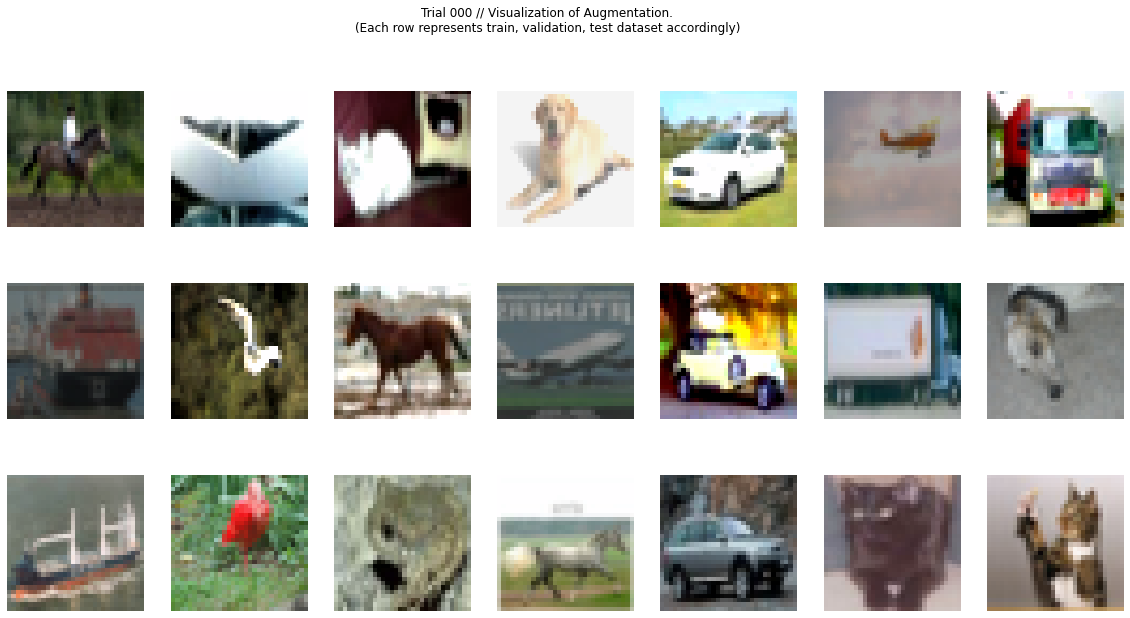

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.083, Acc: 22.38% F1(macro): 0.22: 100%|██████████| 156/156 [00:12<00:00, 12.91it/s]
 Val:       Loss: 1.869, Acc: 31.06% F1(macro): 0.30: 100%|██████████| 40/40 [00:02<00:00, 17.45it/s]


Model saved. Current best test f1: 0.299


Train: [002] Loss: 1.689, Acc: 37.56% F1(macro): 0.37: 100%|██████████| 156/156 [00:12<00:00, 12.92it/s]
 Val:       Loss: 1.618, Acc: 41.15% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s]


Model saved. Current best test f1: 0.394


Train: [003] Loss: 1.532, Acc: 44.09% F1(macro): 0.44: 100%|██████████| 156/156 [00:12<00:00, 12.82it/s]
 Val:       Loss: 1.497, Acc: 45.06% F1(macro): 0.45: 100%|██████████| 40/40 [00:02<00:00, 16.92it/s]


Model saved. Current best test f1: 0.446


Train: [004] Loss: 1.432, Acc: 48.06% F1(macro): 0.48: 100%|██████████| 156/156 [00:11<00:00, 13.09it/s]
 Val:       Loss: 1.414, Acc: 48.47% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s]


Model saved. Current best test f1: 0.477


Train: [005] Loss: 1.351, Acc: 51.27% F1(macro): 0.51: 100%|██████████| 156/156 [00:12<00:00, 13.00it/s]
 Val:       Loss: 1.342, Acc: 50.90% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 17.52it/s]


Model saved. Current best test f1: 0.505


Train: [006] Loss: 1.278, Acc: 54.16% F1(macro): 0.54: 100%|██████████| 156/156 [00:11<00:00, 13.01it/s]
 Val:       Loss: 1.285, Acc: 53.75% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 17.81it/s]


Model saved. Current best test f1: 0.536


Train: [007] Loss: 1.218, Acc: 56.51% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 13.24it/s]
 Val:       Loss: 1.230, Acc: 55.89% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s]


Model saved. Current best test f1: 0.558


Train: [008] Loss: 1.153, Acc: 59.07% F1(macro): 0.59: 100%|██████████| 156/156 [00:12<00:00, 12.98it/s]
 Val:       Loss: 1.160, Acc: 58.08% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 16.86it/s]


Model saved. Current best test f1: 0.580


Train: [009] Loss: 1.099, Acc: 60.91% F1(macro): 0.61: 100%|██████████| 156/156 [00:12<00:00, 12.91it/s]
 Val:       Loss: 1.139, Acc: 59.05% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 17.56it/s]


Model saved. Current best test f1: 0.583


Train: [010] Loss: 1.052, Acc: 62.67% F1(macro): 0.63: 100%|██████████| 156/156 [00:12<00:00, 12.91it/s]
 Val:       Loss: 1.115, Acc: 60.25% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 17.00it/s]


Model saved. Current best test f1: 0.600
TEST DATASET


 Val:       Loss: 1.066, Acc: 61.95% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 34.99it/s]
[I 2021-11-24 03:49:58,945] Trial 0 finished with value: 0.6151110299556382 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 0 with value: 0.6151110299556382.


Files already downloaded and verified
Files already downloaded and verified


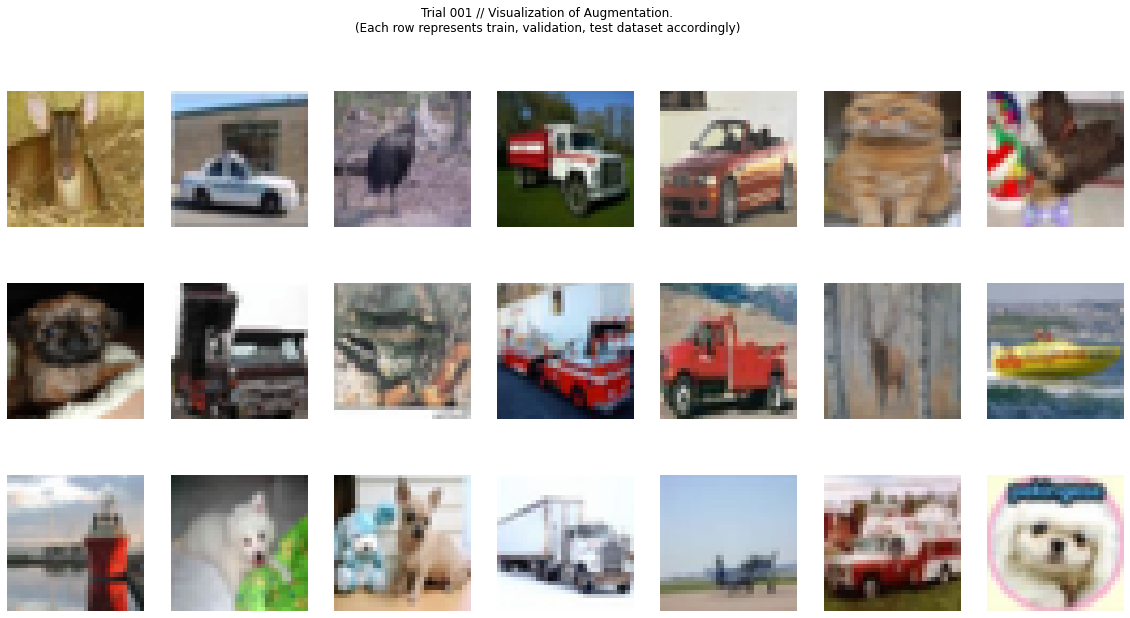

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.910, Acc: 28.90% F1(macro): 0.29: 100%|██████████| 156/156 [00:11<00:00, 13.53it/s]
 Val:       Loss: 1.655, Acc: 39.99% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 33.48it/s]


Model saved. Current best test f1: 0.387


Train: [002] Loss: 1.496, Acc: 45.35% F1(macro): 0.45: 100%|██████████| 156/156 [00:11<00:00, 13.53it/s]
 Val:       Loss: 1.440, Acc: 47.32% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 33.29it/s]


Model saved. Current best test f1: 0.465


Train: [003] Loss: 1.354, Acc: 51.17% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 13.51it/s]
 Val:       Loss: 1.360, Acc: 51.51% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 32.51it/s]


Model saved. Current best test f1: 0.509


Train: [004] Loss: 1.256, Acc: 54.88% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 13.40it/s]
 Val:       Loss: 1.290, Acc: 53.65% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 34.07it/s]


Model saved. Current best test f1: 0.531


Train: [005] Loss: 1.181, Acc: 57.92% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 13.45it/s]
 Val:       Loss: 1.209, Acc: 56.47% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 34.60it/s]


Model saved. Current best test f1: 0.565


Train: [006] Loss: 1.116, Acc: 60.51% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 13.40it/s]
 Val:       Loss: 1.195, Acc: 57.76% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 33.48it/s]


Model saved. Current best test f1: 0.576


Train: [007] Loss: 1.048, Acc: 62.59% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 13.11it/s]
 Val:       Loss: 1.147, Acc: 59.49% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 33.83it/s]


Model saved. Current best test f1: 0.593


Train: [008] Loss: 0.999, Acc: 64.24% F1(macro): 0.64: 100%|██████████| 156/156 [00:11<00:00, 13.48it/s]
 Val:       Loss: 1.088, Acc: 61.90% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 33.51it/s]


Model saved. Current best test f1: 0.617


Train: [009] Loss: 0.947, Acc: 66.52% F1(macro): 0.66: 100%|██████████| 156/156 [00:11<00:00, 13.67it/s]
 Val:       Loss: 1.067, Acc: 62.73% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 34.82it/s]


Model saved. Current best test f1: 0.626


Train: [010] Loss: 0.916, Acc: 67.55% F1(macro): 0.67: 100%|██████████| 156/156 [00:11<00:00, 13.59it/s]
 Val:       Loss: 1.013, Acc: 64.19% F1(macro): 0.64: 100%|██████████| 40/40 [00:01<00:00, 34.83it/s]


Model saved. Current best test f1: 0.640
TEST DATASET


 Val:       Loss: 1.046, Acc: 63.06% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 36.55it/s]
[I 2021-11-24 03:52:23,092] Trial 1 finished with value: 0.6284039991727963 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 1 with value: 0.6284039991727963.


Files already downloaded and verified
Files already downloaded and verified


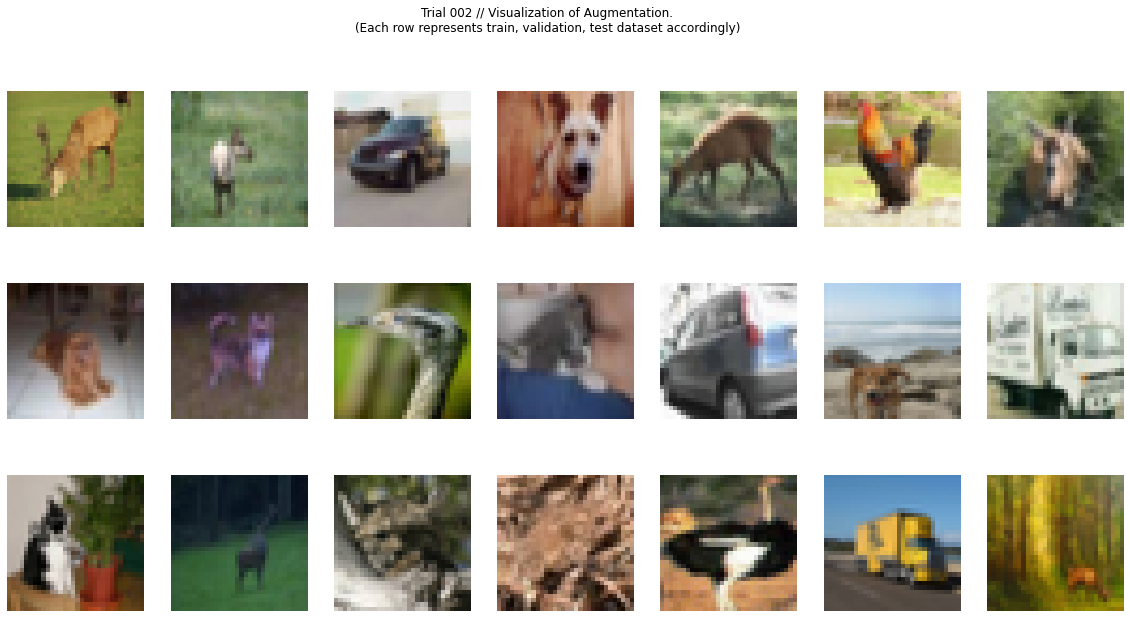

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

Train: [001] Loss: 1.891, Acc: 29.70% F1(macro): 0.29: 100%|██████████| 156/156 [00:11<00:00, 14.17it/s]
 Val:       Loss: 1.649, Acc: 40.33% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 35.26it/s]


Model saved. Current best test f1: 0.393


Train: [002] Loss: 1.500, Acc: 44.94% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 14.01it/s]
 Val:       Loss: 1.453, Acc: 47.13% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 33.18it/s]


Model saved. Current best test f1: 0.465


Train: [003] Loss: 1.358, Acc: 50.69% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 14.16it/s]
 Val:       Loss: 1.363, Acc: 51.15% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 35.04it/s]


Model saved. Current best test f1: 0.511


Train: [004] Loss: 1.245, Acc: 54.94% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 14.06it/s]
 Val:       Loss: 1.257, Acc: 55.44% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 32.85it/s]


Model saved. Current best test f1: 0.553


Train: [005] Loss: 1.159, Acc: 58.33% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.205, Acc: 57.01% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 36.82it/s]


Model saved. Current best test f1: 0.567


Train: [006] Loss: 1.087, Acc: 61.09% F1(macro): 0.61: 100%|██████████| 156/156 [00:11<00:00, 13.77it/s]
 Val:       Loss: 1.176, Acc: 58.22% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 33.92it/s]


Model saved. Current best test f1: 0.582


Train: [007] Loss: 1.032, Acc: 63.15% F1(macro): 0.63: 100%|██████████| 156/156 [00:11<00:00, 14.05it/s]
 Val:       Loss: 1.127, Acc: 60.11% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 35.70it/s]


Model saved. Current best test f1: 0.602


Train: [008] Loss: 0.972, Acc: 65.31% F1(macro): 0.65: 100%|██████████| 156/156 [00:11<00:00, 13.96it/s]
 Val:       Loss: 1.099, Acc: 61.30% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 33.46it/s]


Model saved. Current best test f1: 0.605


Train: [009] Loss: 0.926, Acc: 67.01% F1(macro): 0.67: 100%|██████████| 156/156 [00:11<00:00, 13.47it/s]
 Val:       Loss: 1.044, Acc: 63.35% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 35.35it/s]


Model saved. Current best test f1: 0.633


Train: [010] Loss: 0.883, Acc: 68.60% F1(macro): 0.68: 100%|██████████| 156/156 [00:11<00:00, 14.09it/s]
 Val:       Loss: 1.031, Acc: 63.44% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 34.55it/s]


Model saved. Current best test f1: 0.633
TEST DATASET


 Val:       Loss: 1.022, Acc: 63.45% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 36.00it/s]
[I 2021-11-24 03:54:42,274] Trial 2 finished with value: 0.633219005500436 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 2 with value: 0.633219005500436.


Files already downloaded and verified
Files already downloaded and verified


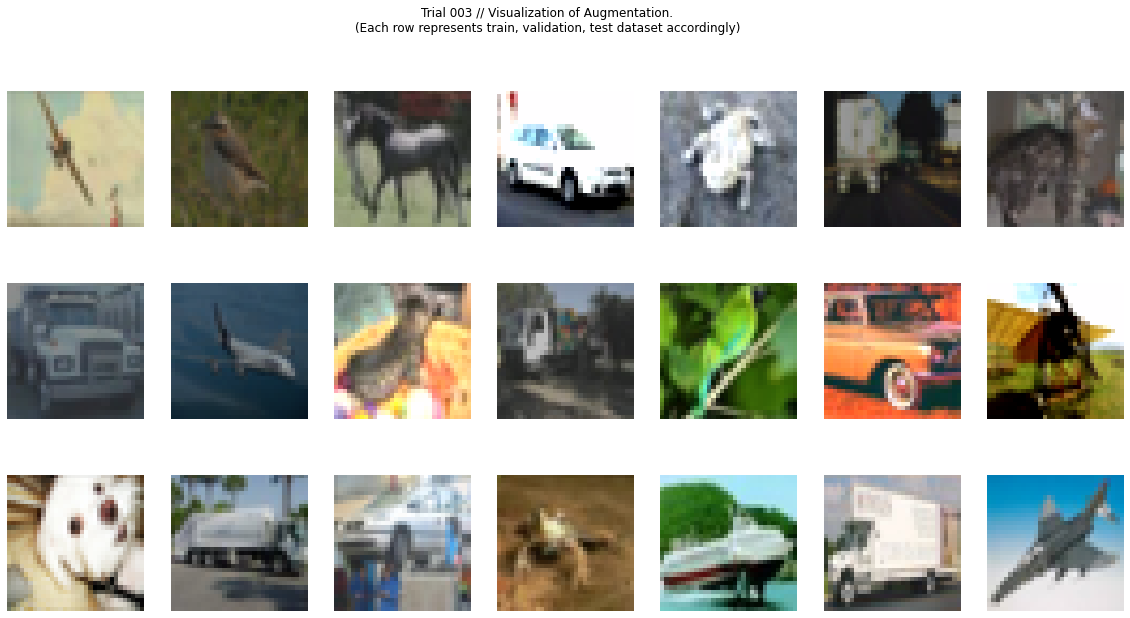

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.057, Acc: 23.40% F1(macro): 0.23: 100%|██████████| 156/156 [00:11<00:00, 13.32it/s]
 Val:       Loss: 1.800, Acc: 33.98% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 15.68it/s]


Model saved. Current best test f1: 0.318


Train: [002] Loss: 1.673, Acc: 38.47% F1(macro): 0.38: 100%|██████████| 156/156 [00:11<00:00, 13.73it/s]
 Val:       Loss: 1.585, Acc: 42.11% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


Model saved. Current best test f1: 0.416


Train: [003] Loss: 1.533, Acc: 44.17% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.70it/s]
 Val:       Loss: 1.488, Acc: 46.28% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s]


Model saved. Current best test f1: 0.456


Train: [004] Loss: 1.443, Acc: 47.24% F1(macro): 0.47: 100%|██████████| 156/156 [00:11<00:00, 13.80it/s]
 Val:       Loss: 1.419, Acc: 48.84% F1(macro): 0.48: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s]


Model saved. Current best test f1: 0.481


Train: [005] Loss: 1.377, Acc: 50.16% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.59it/s]
 Val:       Loss: 1.359, Acc: 50.36% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s]


Model saved. Current best test f1: 0.499


Train: [006] Loss: 1.318, Acc: 52.57% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 13.61it/s]
 Val:       Loss: 1.349, Acc: 51.95% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 18.11it/s]


Model saved. Current best test f1: 0.512


Train: [007] Loss: 1.262, Acc: 54.30% F1(macro): 0.54: 100%|██████████| 156/156 [00:11<00:00, 13.87it/s]
 Val:       Loss: 1.269, Acc: 54.65% F1(macro): 0.54: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


Model saved. Current best test f1: 0.543


Train: [008] Loss: 1.212, Acc: 56.57% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 13.65it/s]
 Val:       Loss: 1.223, Acc: 56.72% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s]


Model saved. Current best test f1: 0.561


Train: [009] Loss: 1.160, Acc: 58.72% F1(macro): 0.59: 100%|██████████| 156/156 [00:11<00:00, 13.66it/s]
 Val:       Loss: 1.196, Acc: 57.17% F1(macro): 0.56: 100%|██████████| 40/40 [00:02<00:00, 17.43it/s]


Model saved. Current best test f1: 0.565


Train: [010] Loss: 1.108, Acc: 60.45% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 13.54it/s]
 Val:       Loss: 1.150, Acc: 59.18% F1(macro): 0.59: 100%|██████████| 40/40 [00:02<00:00, 17.23it/s]


Model saved. Current best test f1: 0.588
TEST DATASET


 Val:       Loss: 1.109, Acc: 61.10% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 35.70it/s]
[I 2021-11-24 03:57:16,069] Trial 3 finished with value: 0.6066876706325964 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 2 with value: 0.633219005500436.


Files already downloaded and verified
Files already downloaded and verified


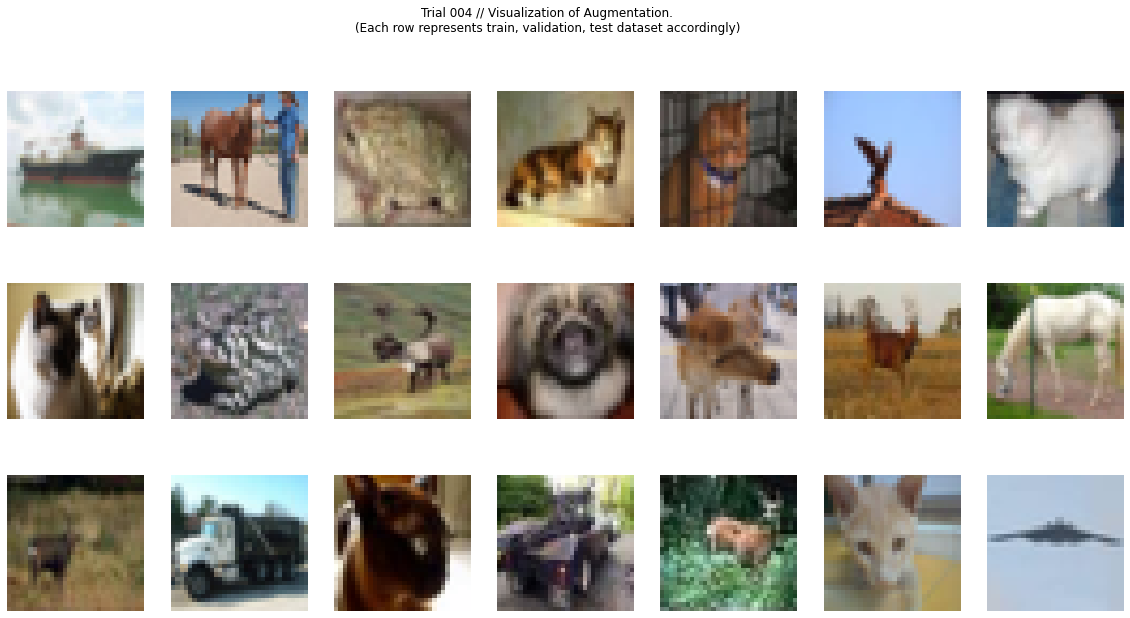

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.937, Acc: 28.10% F1(macro): 0.28: 100%|██████████| 156/156 [00:10<00:00, 14.34it/s]
 Val:       Loss: 1.678, Acc: 40.23% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 35.44it/s]


Model saved. Current best test f1: 0.391


Train: [002] Loss: 1.508, Acc: 44.48% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 14.12it/s]
 Val:       Loss: 1.444, Acc: 47.20% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 36.29it/s]


Model saved. Current best test f1: 0.468


Train: [003] Loss: 1.352, Acc: 51.06% F1(macro): 0.51: 100%|██████████| 156/156 [00:11<00:00, 13.93it/s]
 Val:       Loss: 1.362, Acc: 50.56% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 36.49it/s]


Model saved. Current best test f1: 0.503


Train: [004] Loss: 1.236, Acc: 55.42% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.55it/s]
 Val:       Loss: 1.317, Acc: 53.70% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 36.72it/s]


Model saved. Current best test f1: 0.533


Train: [005] Loss: 1.138, Acc: 58.99% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 14.64it/s]
 Val:       Loss: 1.274, Acc: 56.06% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 35.23it/s]


Model saved. Current best test f1: 0.560


Train: [006] Loss: 1.050, Acc: 62.32% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 15.01it/s]
 Val:       Loss: 1.227, Acc: 57.22% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 37.99it/s]


Model saved. Current best test f1: 0.573


Train: [007] Loss: 0.976, Acc: 65.18% F1(macro): 0.65: 100%|██████████| 156/156 [00:11<00:00, 13.50it/s]
 Val:       Loss: 1.222, Acc: 58.07% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.31it/s]


Model saved. Current best test f1: 0.581


Train: [008] Loss: 0.920, Acc: 67.26% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 14.80it/s]
 Val:       Loss: 1.207, Acc: 57.79% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 37.75it/s]
Train: [009] Loss: 0.871, Acc: 69.19% F1(macro): 0.69: 100%|██████████| 156/156 [00:10<00:00, 14.38it/s]
 Val:       Loss: 1.218, Acc: 58.68% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 38.80it/s]


Model saved. Current best test f1: 0.592


Train: [010] Loss: 0.829, Acc: 70.70% F1(macro): 0.71: 100%|██████████| 156/156 [00:10<00:00, 14.42it/s]
 Val:       Loss: 1.213, Acc: 59.03% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 35.54it/s]


Model saved. Current best test f1: 0.593
TEST DATASET


 Val:       Loss: 1.212, Acc: 58.48% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 37.49it/s]
[I 2021-11-24 03:59:30,780] Trial 4 finished with value: 0.5861884327003145 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 2 with value: 0.633219005500436.


Files already downloaded and verified
Files already downloaded and verified


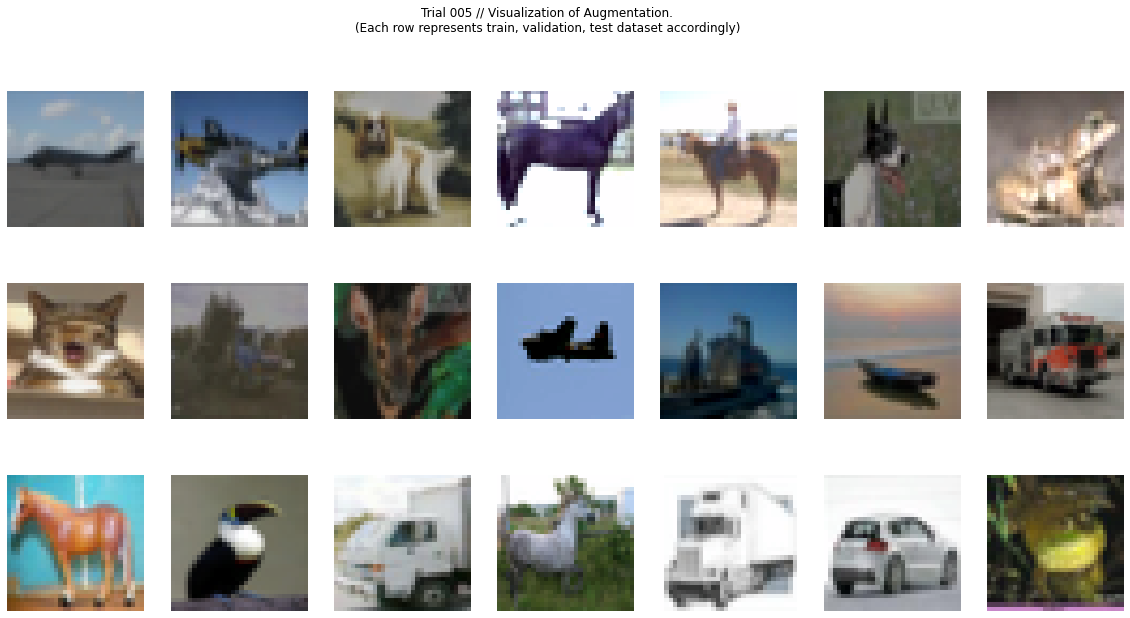

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

Train: [001] Loss: 2.037, Acc: 24.01% F1(macro): 0.24: 100%|██████████| 156/156 [00:11<00:00, 13.46it/s]
 Val:       Loss: 1.786, Acc: 32.97% F1(macro): 0.31: 100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


Model saved. Current best test f1: 0.314


Train: [002] Loss: 1.668, Acc: 38.44% F1(macro): 0.38: 100%|██████████| 156/156 [00:12<00:00, 12.83it/s]
 Val:       Loss: 1.645, Acc: 40.29% F1(macro): 0.39: 100%|██████████| 40/40 [00:02<00:00, 17.65it/s]


Model saved. Current best test f1: 0.389


Train: [003] Loss: 1.520, Acc: 44.34% F1(macro): 0.44: 100%|██████████| 156/156 [00:11<00:00, 13.67it/s]
 Val:       Loss: 1.484, Acc: 46.62% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 16.84it/s]


Model saved. Current best test f1: 0.464


Train: [004] Loss: 1.404, Acc: 49.28% F1(macro): 0.49: 100%|██████████| 156/156 [00:11<00:00, 13.47it/s]
 Val:       Loss: 1.355, Acc: 51.43% F1(macro): 0.51: 100%|██████████| 40/40 [00:02<00:00, 17.63it/s]


Model saved. Current best test f1: 0.510


Train: [005] Loss: 1.315, Acc: 52.52% F1(macro): 0.52: 100%|██████████| 156/156 [00:11<00:00, 13.12it/s]
 Val:       Loss: 1.302, Acc: 52.97% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 17.79it/s]


Model saved. Current best test f1: 0.520


Train: [006] Loss: 1.226, Acc: 55.93% F1(macro): 0.56: 100%|██████████| 156/156 [00:11<00:00, 13.62it/s]
 Val:       Loss: 1.222, Acc: 55.84% F1(macro): 0.55: 100%|██████████| 40/40 [00:02<00:00, 15.64it/s]


Model saved. Current best test f1: 0.554


Train: [007] Loss: 1.172, Acc: 58.03% F1(macro): 0.58: 100%|██████████| 156/156 [00:11<00:00, 13.44it/s]
 Val:       Loss: 1.207, Acc: 57.13% F1(macro): 0.57: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s]


Model saved. Current best test f1: 0.567


Train: [008] Loss: 1.119, Acc: 59.96% F1(macro): 0.60: 100%|██████████| 156/156 [00:11<00:00, 13.41it/s]
 Val:       Loss: 1.165, Acc: 58.86% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 17.75it/s]


Model saved. Current best test f1: 0.585


Train: [009] Loss: 1.066, Acc: 61.92% F1(macro): 0.62: 100%|██████████| 156/156 [00:11<00:00, 13.25it/s]
 Val:       Loss: 1.109, Acc: 59.98% F1(macro): 0.60: 100%|██████████| 40/40 [00:02<00:00, 17.54it/s]


Model saved. Current best test f1: 0.599


Train: [010] Loss: 1.035, Acc: 63.25% F1(macro): 0.63: 100%|██████████| 156/156 [00:11<00:00, 13.06it/s]
 Val:       Loss: 1.090, Acc: 60.90% F1(macro): 0.61: 100%|██████████| 40/40 [00:02<00:00, 17.15it/s]


Model saved. Current best test f1: 0.608
TEST DATASET


 Val:       Loss: 1.050, Acc: 62.76% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 35.58it/s]
[I 2021-11-24 04:02:07,263] Trial 5 finished with value: 0.6251912932393611 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 2 with value: 0.633219005500436.


Files already downloaded and verified
Files already downloaded and verified


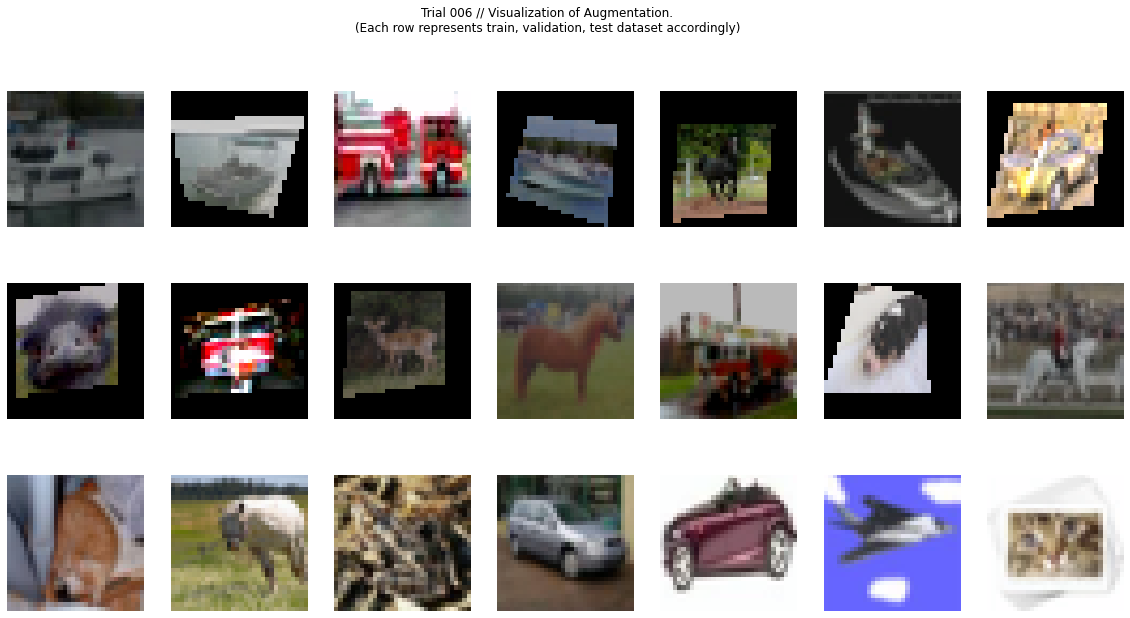

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40    

Train: [001] Loss: 2.118, Acc: 20.55% F1(macro): 0.20: 100%|██████████| 156/156 [00:11<00:00, 13.32it/s]
 Val:       Loss: 1.960, Acc: 28.80% F1(macro): 0.26: 100%|██████████| 40/40 [00:02<00:00, 15.60it/s]


Model saved. Current best test f1: 0.261


Train: [002] Loss: 1.815, Acc: 32.38% F1(macro): 0.31: 100%|██████████| 156/156 [00:11<00:00, 13.43it/s]
 Val:       Loss: 1.718, Acc: 36.16% F1(macro): 0.35: 100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Model saved. Current best test f1: 0.348


Train: [003] Loss: 1.695, Acc: 37.28% F1(macro): 0.37:  85%|████████▍ | 132/156 [00:09<00:01, 14.07it/s]


KeyboardInterrupt: 

In [9]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)